In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np

from mfpml.design_of_experiment.multifidelity_samplers import (
    MFLatinHyperCube,
    MFSobolSequence,
)
from mfpml.models.co_kriging import CoKriging
from mfpml.models.hierarchical_kriging import HierarchicalKriging
from mfpml.models.scale_kriging import ScaledKriging
from mfpml.optimization.evolutionary_algorithms import PSO
from mfpml.problems.multifidelity_functions import Forrester_1b

In [11]:
# define function
func = Forrester_1b()
# define sampler
sampler = MFSobolSequence(design_space=func._input_domain,
                          num_fidelity=2)
# sample_x = sampler.get_samples(num_samples=[4, 11])
sample_xh = np.array([0, 0.4, 0.6, 1.0]).reshape(-1, 1)
sample_xl = np.linspace(0, 1, 11).reshape(-1, 1)
sample_x = [sample_xh, sample_xl]
sample_y = func(sample_x)

# generate test samples
test_x = np.linspace(0, 1, 1000).reshape(-1, 1)
test_hy = func.hf(test_x)
test_ly = func.lf(test_x)

# Co-Kriging model


In [12]:
coK = CoKriging(design_space=func._input_domain,
                optimizer_restart=10, noise_prior=0.0)
coK.train(sample_x,
          sample_y)
print(coK.noise)
cok_pre, cok_mse = coK.predict(test_x, return_std=True)
lf_pred, lf_std = coK.lfGP.predict(
    test_x, return_std=True)
lf_pred = lf_pred*coK.yh_std + coK.yh_mean
lf_std = lf_std*coK.yh_std
# print training time
print(coK.lf_training_time, coK.hf_training_time)

0.0
2.2769274711608887 0.24387168884277344


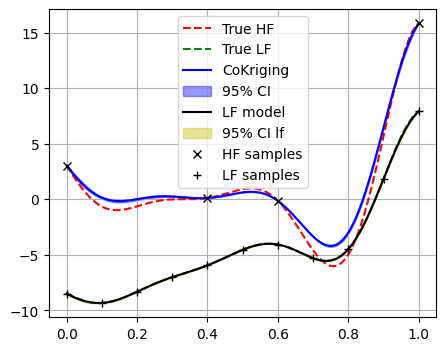

In [13]:
fig, ax = plt.subplots(figsize=(5, 4))
plt.plot(test_x, test_hy, "r--", label="True HF")
plt.plot(test_x, test_ly, "g--", label="True LF")
plt.plot(test_x, cok_pre, "b-", label="CoKriging")
plt.fill_between(
    test_x[:, 0],
    cok_pre[:, 0] - 1.96 * cok_mse[:, 0],
    cok_pre[:, 0] + 1.96 * cok_mse[:, 0],
    alpha=0.4,
    color="b",
    label="95% CI",
)
plt.plot(test_x, lf_pred, "k-", label="LF model")
plt.fill_between(
    test_x[:, 0],
    lf_pred[:, 0] - 1.96 * lf_std[:, 0],
    lf_pred[:, 0] + 1.96 * lf_std[:, 0],
    alpha=0.4,
    color="y",
    label="95% CI lf",
)
plt.plot(sample_x[0], sample_y[0], "kx", label="HF samples")
plt.plot(sample_x[1], sample_y[1], "k+", label="LF samples")
plt.legend(loc="best")
plt.grid()
plt.show()

# Scaled Kriging without optimizing rho


In [5]:
ScK = ScaledKriging(design_space=func._input_domain,
                    optimizer_restart=20, noise_prior=0.0)
ScK.train(sample_x, sample_y)
sck_pre, sck_std = ScK.predict(test_x, return_std=True)
lf_pred, lf_std = ScK.lfGP.predict(test_x, return_std=True)

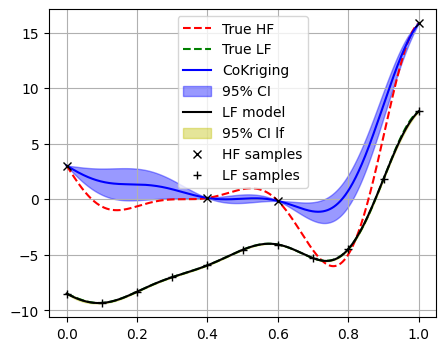

In [6]:
fig, ax = plt.subplots(figsize=(5, 4))
plt.plot(test_x, test_hy, "r--", label="True HF")
plt.plot(test_x, test_ly, "g--", label="True LF")
plt.plot(test_x, sck_pre, "b-", label="CoKriging")
plt.fill_between(
    test_x[:, 0],
    sck_pre[:, 0] - 1.96 * sck_std[:, 0],
    sck_pre[:, 0] + 1.96 * sck_std[:, 0],
    alpha=0.4,
    color="b",
    label="95% CI",
)
plt.plot(test_x, lf_pred, "k-", label="LF model")
plt.fill_between(
    test_x[:, 0],
    lf_pred[:, 0] - 1.96 * lf_std[:, 0],
    lf_pred[:, 0] + 1.96 * lf_std[:, 0],
    alpha=0.4,
    color="y",
    label="95% CI lf",
)
plt.plot(sample_x[0], sample_y[0], "kx", label="HF samples")
plt.plot(sample_x[1], sample_y[1], "k+", label="LF samples")
plt.legend(loc="best")
plt.grid()
plt.show()

# Scaled Kriging with optimizing rho


In [7]:
pso_opt = PSO(num_gen=200, num_pop=20)
ScKrho = ScaledKriging(
    design_space=func._input_domain,
    rho_optimizer=True,
    rho_method="error",
    rho_bound=[0.0, 10.0],
    optimizer=pso_opt,
)
ScKrho.train(sample_x, sample_y)
ScKrho_pred, ScKrho_std = ScKrho.predict(test_x, return_std=True)
lf_pred, lf_std = ScKrho.lfGP.predict(test_x, return_std=True)

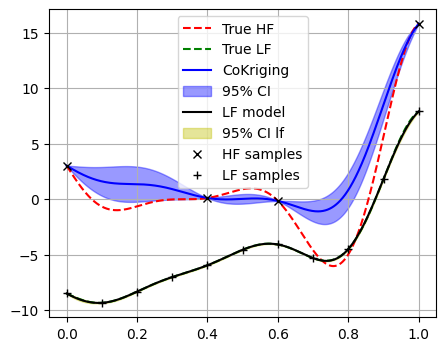

In [8]:
fig, ax = plt.subplots(figsize=(5, 4))
plt.plot(test_x, test_hy, "r--", label="True HF")
plt.plot(test_x, test_ly, "g--", label="True LF")
plt.plot(test_x, ScKrho_pred, "b-", label="CoKriging")
plt.fill_between(
    test_x[:, 0],
    ScKrho_pred[:, 0] - 1.96 * ScKrho_std[:, 0],
    ScKrho_pred[:, 0] + 1.96 * ScKrho_std[:, 0],
    alpha=0.4,
    color="b",
    label="95% CI",
)
plt.plot(test_x, lf_pred, "k-", label="LF model")
plt.fill_between(
    test_x[:, 0],
    lf_pred[:, 0] - 1.96 * lf_std[:, 0],
    lf_pred[:, 0] + 1.96 * lf_std[:, 0],
    alpha=0.4,
    color="y",
    label="95% CI lf",
)
plt.plot(sample_x[0], sample_y[0], "kx", label="HF samples")
plt.plot(sample_x[1], sample_y[1], "k+", label="LF samples")
plt.legend(loc="best")
plt.grid()
plt.show()

# Hierarchical Kriging


In [9]:
pso_opt = PSO(num_gen=200, num_pop=20)
HK = HierarchicalKriging(design_space=func._input_domain,
                         noise_prior=0.0)
HK.train(sample_x, sample_y)
hk_pre, hk_std = HK.predict(test_x, return_std=True)
lf_pred, lf_std = HK.lfGP.predict(test_x, return_std=True)

HK.beta

array([[1.99326143]])

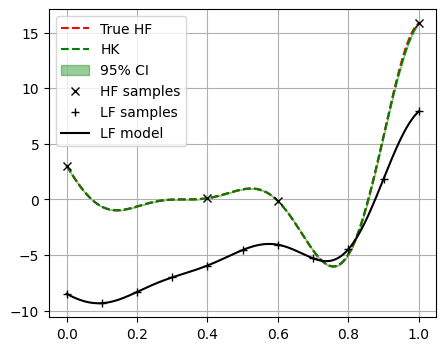

In [10]:
fig, ax = plt.subplots(figsize=(5, 4))
plt.plot(test_x, test_hy, "r--", label="True HF")
plt.plot(test_x, hk_pre, "g--", label="HK")
plt.fill_between(
    test_x[:, 0],
    hk_pre[:, 0] - 1.96 * hk_std[:, 0],
    hk_pre[:, 0] + 1.96 * hk_std[:, 0],
    alpha=0.4,
    color="g",
    label="95% CI",
)
plt.plot(sample_x[0], sample_y[0], "kx", label="HF samples")
plt.plot(sample_x[1], sample_y[1], "k+", label="LF samples")
plt.plot(test_x, lf_pred, "k-", label="LF model")
plt.legend(loc="best")
plt.grid()
plt.show()